# Summary

**Phase 1**

We looked at the variables' overall distributions, and their distributions conditional on earning 50k+ vs not 50k+. We found that people earning 50k+ tended to be 30-60, working full time or married to someone working full time, and had large capital gains/losses/dividends. 

**Phase 2**

We created some new variables to help the model exclude some observations (children), created a new variable to identify a trend (high capital), and edited others to give more information in condensed form to the model (race - removed hispanic variable, split up white into hispanic/non hispanic). 

**Phase 3-6**

After a bit of pre-processing, we tried a logistic regression, but we had to encode all the categorical variables - leaving us with 164 features. The model is slow, doesn't converge, and can't take all our variables. 
Because we had a mix of categorical and numeric variables, we felt decision trees would also work, and could run faster. We tried a decision tree, but it was significantly over-fitting the data. To guard against this, we used a random forest which aggregates and averages decision trees. This is still over_fitting, but it's the best we can do.

**Conclusion**

Our final model has a 4.5% error rate, and correctly identifies 36.5% of the individuals with 50k+ income. It seems the key drivers of this model are weeks worked, whether a person has significant capital fluctuation, age, occupation, working at a big or small company, education and sex.

Depending on what we might want to use this model for (marketing purposes?), we may be willing to accept a higher error rate if we can correctly identify more of the individuals (tradeoff recall for error rate). To do this, we could slightly change the model a little (lower the threshold).

In [20]:
#Importing some basic packages to explore
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import zipfile
import scipy.stats
import seaborn as sns
%matplotlib inline

# Step 0: loading in data

What I'm doing: file import, change field names to something intuitive, break up variables by type

Anything interesting?
- Note the data uses stratified sample, inst_weight will be needed to do any real analysis

In [21]:
#load in files, variable names

zipf=zipfile.ZipFile('C:/Users/Baptiste/Documents/Python Scripts/us_census_full.zip')
df=pd.read_csv(zipf.open('us_census_full/census_income_learn.csv'), 
                    index_col=False,
                    header=None,
                    names=['age' , 'class' , 'ind_code' , 'oc_code' , 'edu' , 'wage' , 'enroll' ,
                           'marital' , 'major_indc' ,'major_occc' , 'race' ,'hisp' , 'sex' , 
                           'union' , 'unemp_reas' , 'full_part_time' , 'cap_gains' ,'cap_losses' ,
                           'dividends' , 'tax_filer' ,'region_prev' , 'state_prev' , 'detailed_fam' , 
                           'detailed_house' , 'inst_weight' , 'mig_code_msa' , 'mig_code_reg' ,
                           'mig_code_mreg', 'live_1' ,'mig_sun' , 'employer' , 'fam_pres' , 'country_f' ,
                           'country_m' , 'country_s' , 'cit' , 'enterp' ,'vet_q' , 'vet_ben' , 
                           'weeks_w' , 'year' , 'inc_bin'],
                    )

df_test=pd.read_csv(zipf.open('us_census_full/census_income_test.csv'), 
                    index_col=False,
                    header=None,
                    names=['age' , 'class' , 'ind_code' , 'oc_code' , 'edu' , 'wage' , 'enroll' ,
                           'marital' , 'major_indc' ,'major_occc' , 'race' ,'hisp' , 'sex' , 'union' ,
                           'unemp_reas' , 'full_part_time' , 'cap_gains' ,'cap_losses' , 'dividends' ,
                           'tax_filer' ,'region_prev' , 'state_prev' , 'detailed_fam' , 
                           'detailed_house' , 'inst_weight' , 'mig_code_msa' , 'mig_code_reg' ,
                           'mig_code_mreg', 'live_1' ,'mig_sun' , 'employer' , 'fam_pres' , 'country_f' ,
                           'country_m' , 'country_s' , 'cit' , 'enterp' ,
                           'vet_q' , 'vet_ben' , 'weeks_w' , 'year' , 'inc_bin'],
                    )

In [22]:
#Lists of variables, set inc_bin to binary 0/1

nominal=['class', 'ind_code', 'oc_code', 'edu', 'enroll', 'marital', 'major_indc', 'major_occc', 'race',
         'hisp', 'sex','union','unemp_reas', 'full_part_time', 'tax_filer', 'region_prev', 'state_prev',
         'detailed_fam', 'detailed_house','mig_code_msa','mig_code_reg', 'mig_code_mreg', 'live_1', 
         'mig_sun', 'fam_pres', 'country_f', 'country_m', 'country_s', 'cit','enterp', 'vet_q','vet_ben']
continuous=['age', 'wage', 'cap_gains' , 'cap_losses' , 'dividends', 'employer', 'weeks_w', 'year']

df['inc_bin'] = df['inc_bin'].map({' - 50000.': 0, ' 50000+.': 1})
df_test['inc_bin'] = df_test['inc_bin'].map({' - 50000.': 0, ' 50000+.': 1})


# PHASE 1: EXPLORATORY DATA ANALYSIS
**1.1 - Continuous variables univariate analysis**

What I'm doing: explore continuous variables with 5 stat summary, plot some CDFs and weighted histograms (no 0s for each)
Note that since we're binning, y axis is meaningless (just visual)

Anything interesting?
- Age seems representative, a big chunk of our sample is too young or old to do anything, and isn't very useful
- 95% have no wage or capital gains/losses/dividends. Wage variable may be missing.
- Documentation incorrect: wages are not hourly. of those that have a wage, the mean hourly wage is 978 and min is 20. Most likely monthly or biweekly.
- inst_weight avg 1740, 1740*199523=347m>263m US population in 1994. Represents too many people, there could be redundant observations, or weighting function was rescaled
- Year from 94 to 95 evenly. Could run the analysis twice testing for a difference in year

,age,wage,cap_gains,cap_losses,dividends,employer,weeks_w,year
count,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,55.426908,434.71899,37.313788,197.529533,1.956180,23.174897,94.499672
std,22.310895,274.896454,4697.53128,271.896428,1984.163658,2.365126,24.411488,0.500001
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,94.000000
50%,33.000000,0.000000,0.00000,0.000000,0.000000,1.000000,8.000000,94.000000
75%,50.000000,0.000000,0.00000,0.000000,0.000000,4.000000,52.000000,95.000000
max,90.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,52.000000,95.000000


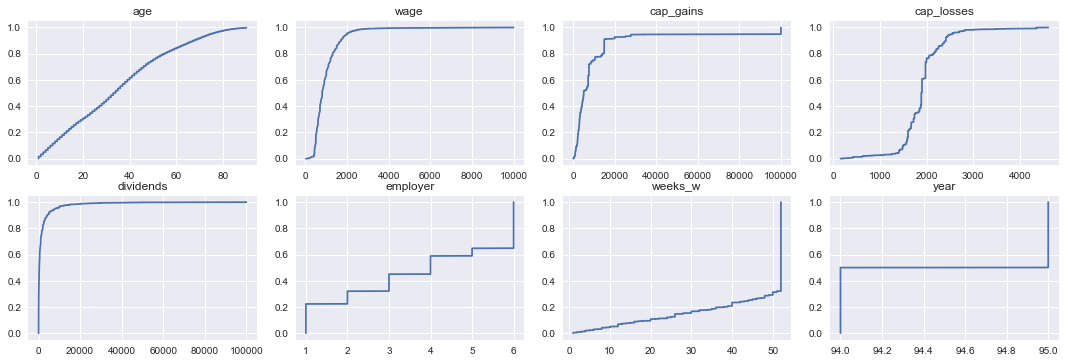

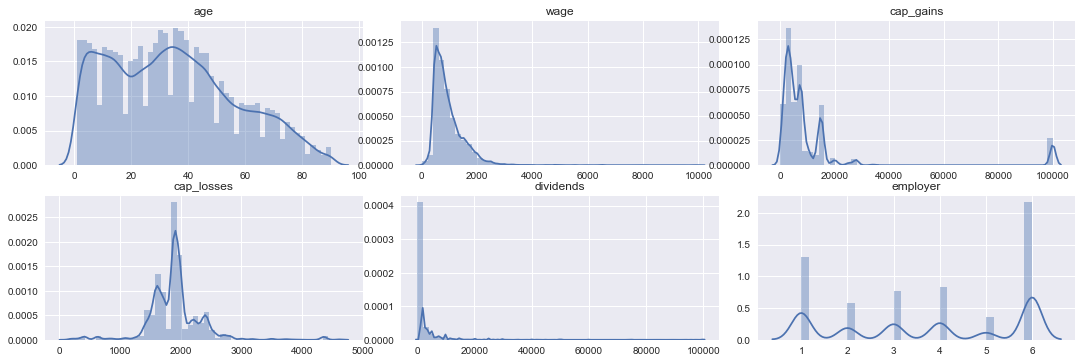

In [23]:
fig, axs = plt.subplots(2,4, figsize=(15,5))
fig.tight_layout()

for ax,i in zip(axs, range(5)):
    for column, j in zip(continuous[4*i:4*(i+1)], range(4)):
        sorted=np.sort(df[column][df[column]!=0])
        yvals=np.arange(len(sorted))/float(len(sorted))
        ax[j].plot(sorted,yvals)
        ax[j].set_title(column)
    
import seaborn as sns
import statsmodels.api as sm

fig1, axs1 = plt.subplots(2,3, figsize=(15,5))
fig1.tight_layout()

for ax, i in zip(axs1, range(2)):
    for column, j in zip(continuous[3*i:3*(i+1)], range(3)):
        weight=df['inst_weight'][df[column]!=0].values
        x=df[column][df[column]!=0].values
        g=sns.distplot(x, norm_hist=True, hist_kws={'weights':weight}, ax=ax[j])
        g.axes.set_title(column)
df[continuous].describe()


 **1.2 Categorical variables univariate analysis**
   
What I'm doing: plotting some bar plots to see the distribution of the variables.
    
Anything interesting?
- 100k (>50%!) unemployed/not in class to be employed, only 28k working full time
- 1/4th are children that live at home, could create a categorical variable 
- 1/4th have a high school degree, only 1/10th have bachelors - probably strongly correlated
- 160k are white - includes 30k hispanics. Could seperate out white and hispanics.
- Only 25k are elligible to join a union. Could be a categorical variable - but should check if this is corr with wage in the US
- 1/2 missing values for mig_code_reg - could discard it
- 50k with veteran benefits - could create categorical variable for armed forces

Hypothesis 
Most interesting (decent variability + possibly correlated with dependent variable) seem to be: class, edu, marital, major_occ, race (+sep hisp), sex, full_part_time, tax_filer, detailed_house 

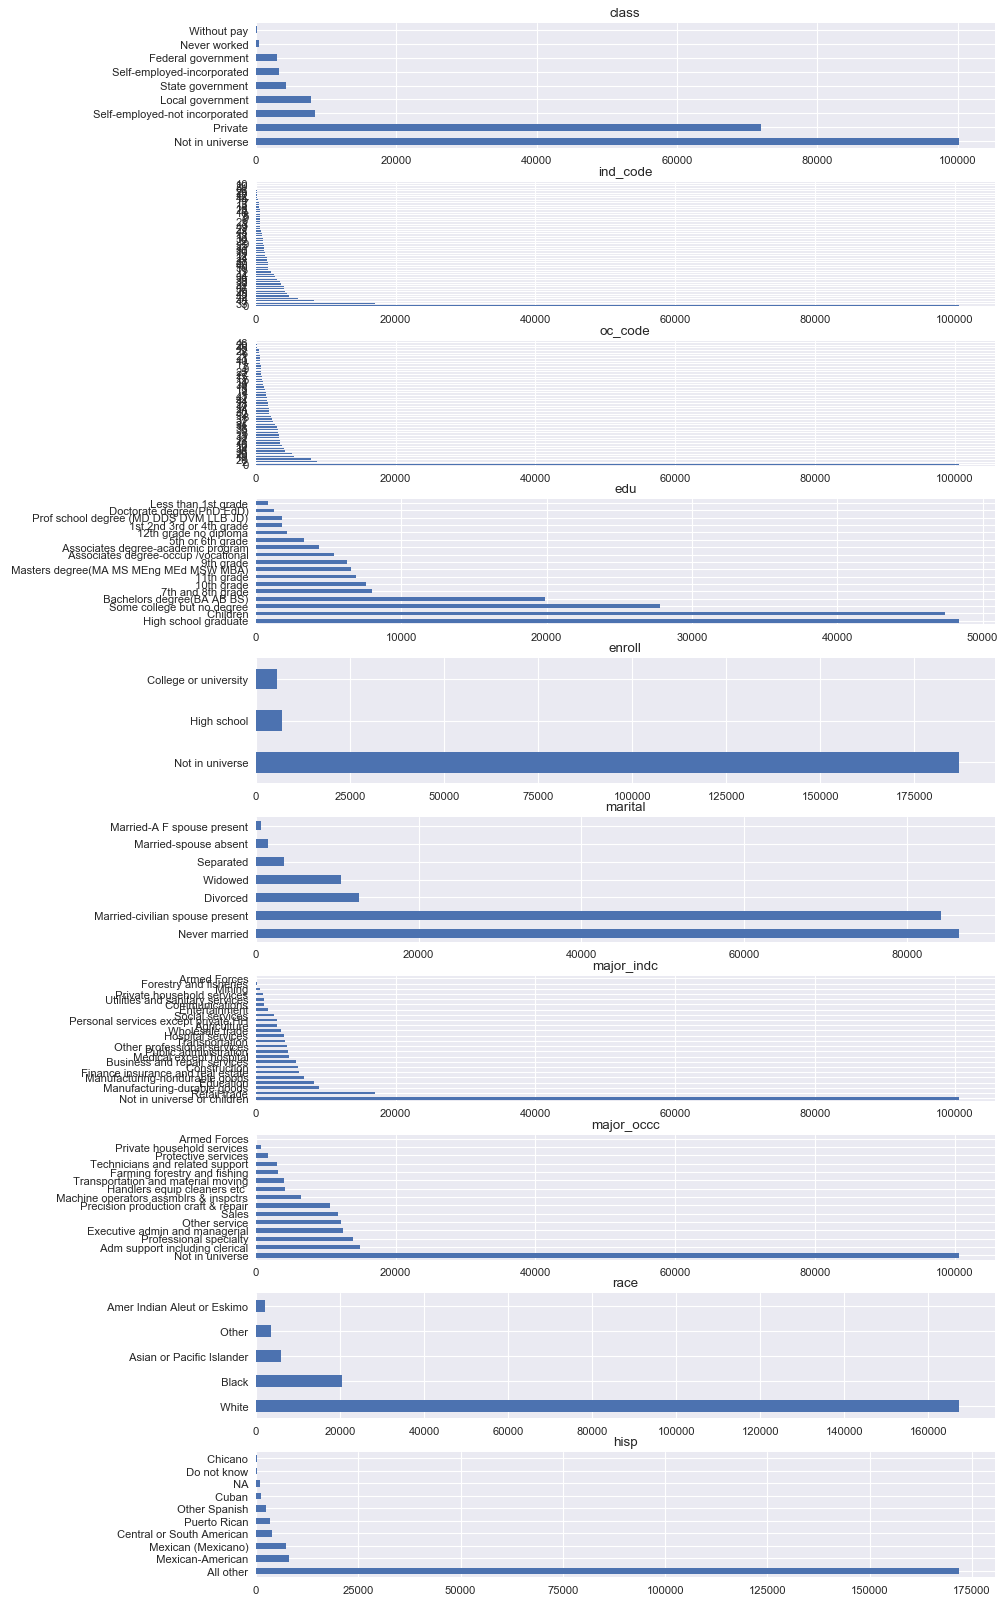

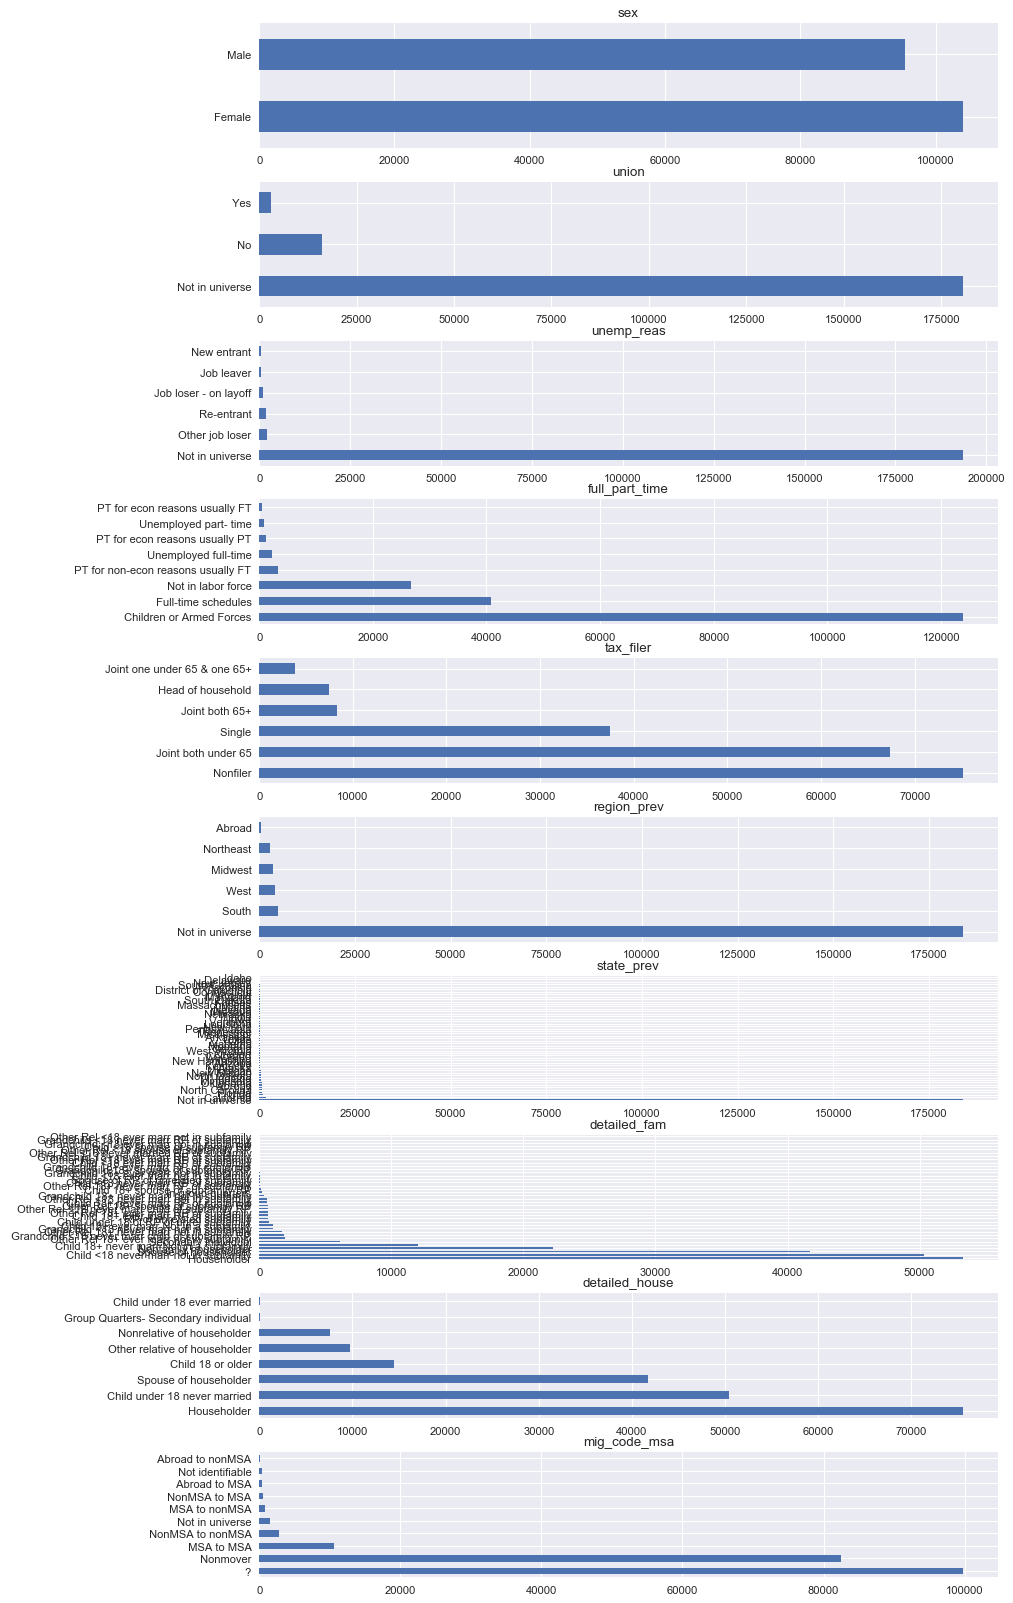

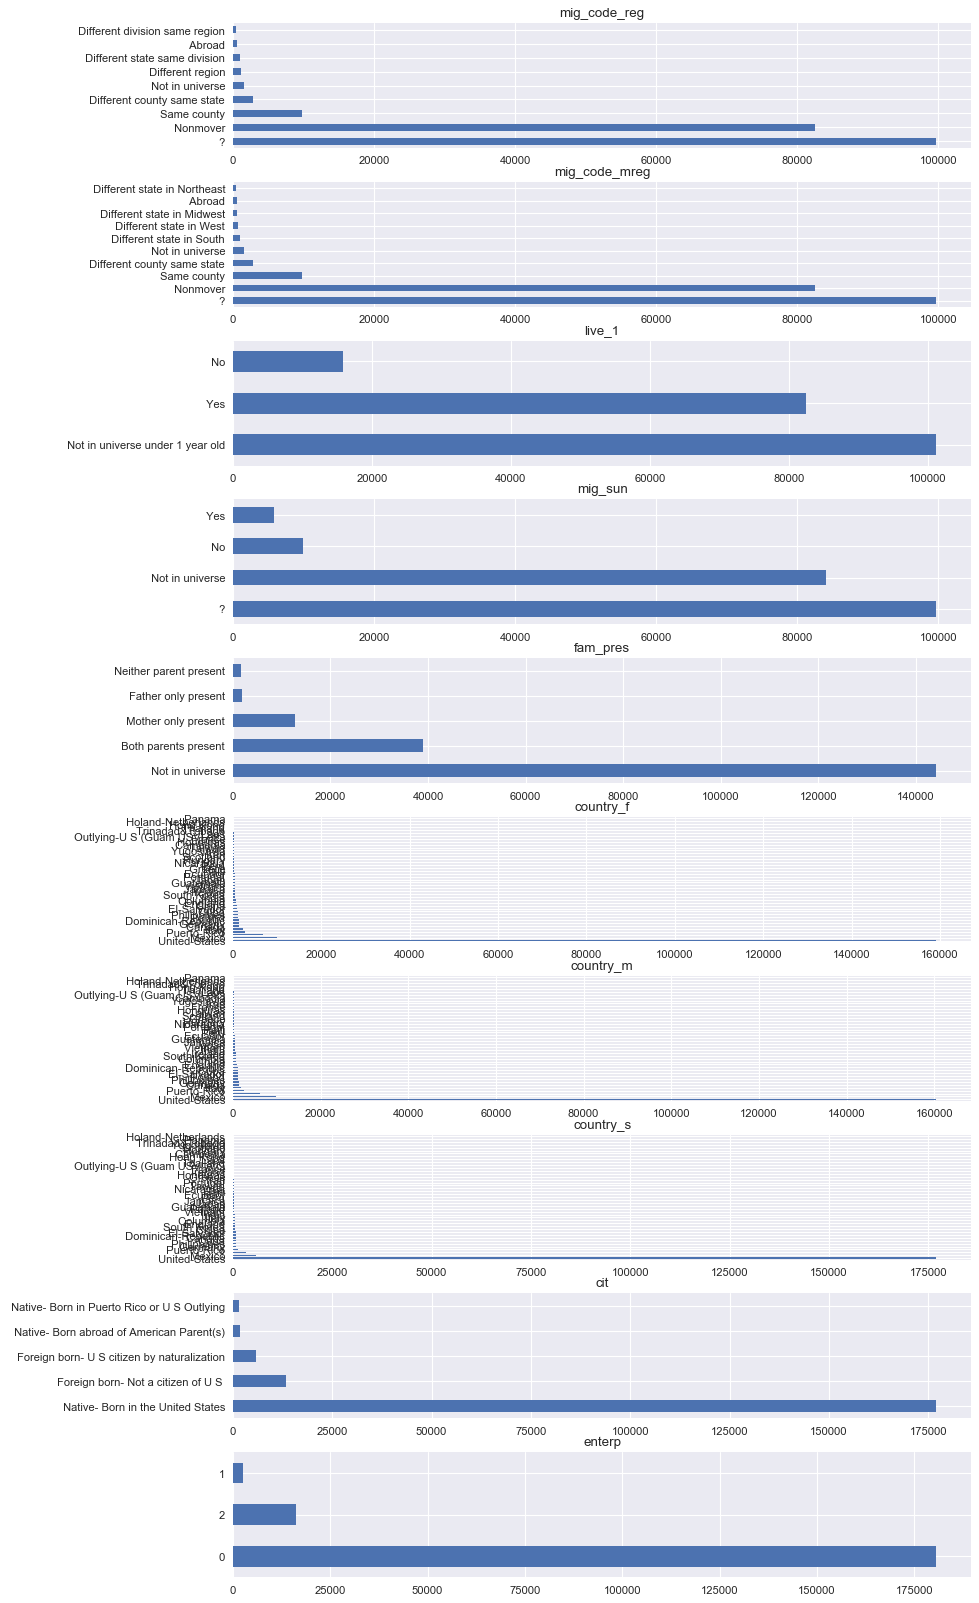

In [24]:
for n in range(3):    
    fig1, axs1 = plt.subplots(10, figsize=(10,20),dpi=80, squeeze=False)
    fig1.tight_layout()
    for ax1,i in zip(axs1, range(10*n, 10*(n+1))):
        column=nominal[i]
        y=df[column].value_counts()
        y.plot.barh(ax=ax1[0])
        ax1[0].set_title(column)


   **1.3 Continuous variables correlation analysis (with each other, with dependent varible) **
   
   What I'm doing: standard correlation matrix, graphing distributions excluding 0s.
   
Anything interesting?
 - wages not too correlated with dividends, cap_gains or cap_losses, even when exclude obs with cap_gains=0
 - wage is poorly correlated with bin_inc -> actually, if look at graph, there are 2 distinct groups.
 - cap_gains is quite a good predictor -> small bump at the edge of the graph, could create a new variable
 - Employer is quite well correlated -> if you work in a bigger company, you're more likely to make lots of money? (Note that graph doesn't capture the strong correlation, as most of the inc_bin=0 population is in employer=0 category)
 - weeks_w is decently correlated, but wage isn't. Maybe a lot of 0 wage stay-home moms/dads skewing the curve
 - age is an N curve - most likely to be 50k+ around 30-60

In [25]:
df.corr()

,age,ind_code,oc_code,wage,cap_gains,cap_losses,dividends,inst_weight,employer,enterp,vet_ben,weeks_w,year,inc_bin
age,1.000000,0.157822,0.117414,0.036938,0.053590,0.063351,0.104976,-0.001611,0.140887,-0.002265,0.674844,0.206181,0.004413,0.135720
ind_code,0.157822,1.000000,0.563493,0.165980,0.066017,0.072586,0.012774,0.029388,0.642096,0.252694,0.476475,0.754472,0.003430,0.196190
oc_code,0.117414,0.563493,1.000000,0.194498,0.002534,0.043680,-0.026726,0.027047,0.515554,0.228952,0.438680,0.655613,-0.003140,0.013414
wage,0.036938,0.165980,0.194498,1.000000,-0.001082,0.010993,-0.005731,0.012353,0.191543,0.054051,0.113094,0.195687,0.002283,0.024528
cap_gains,0.053590,0.066017,0.002534,-0.001082,1.000000,-0.012700,0.131476,0.002549,0.058015,0.015048,0.051530,0.083549,0.005243,0.240725
cap_losses,0.063351,0.072586,0.043680,0.010993,-0.012700,1.000000,0.042427,0.008052,0.084255,0.024116,0.075391,0.100762,0.000096,0.147417
dividends,0.104976,0.012774,-0.026726,-0.005731,0.131476,0.042427,1.000000,-0.000009,0.007206,-0.004885,0.054585,0.013823,0.001913,0.175779
inst_weight,-0.001611,0.029388,0.027047,0.012353,0.002549,0.008052,-0.000009,1.000000,0.042778,0.012328,0.040507,0.029240,0.011765,0.014463
employer,0.140887,0.642096,0.515554,0.191543,0.058015,0.084255,0.007206,0.042778,1.000000,0.240553,0.463334,0.747302,0.018774,0.222684
enterp,-0.002265,0.252694,0.228952,0.054051,0.015048,0.024116,-0.004885,0.012328,0.240553,1.000000,0.177448,0.265872,0.007377,0.040473


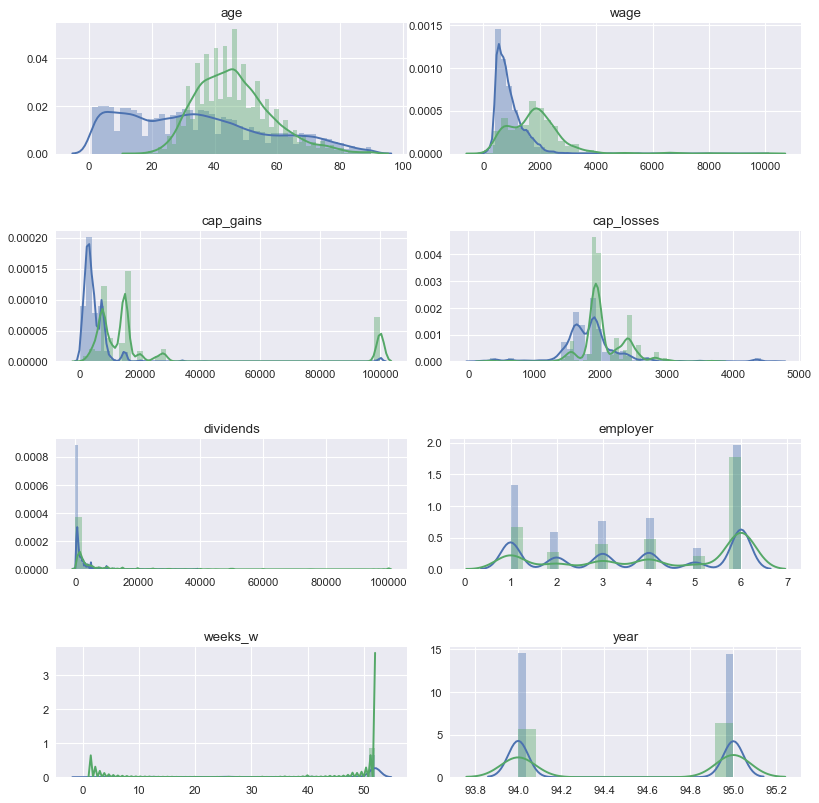

In [26]:
import warnings
warnings.filterwarnings('ignore')

subset_1=df[df['inc_bin']==1]
subset_0=df[df['inc_bin']==0]

#Which variables look interesting?
fig1, axs1 = plt.subplots(4,2, figsize=(10,10),dpi=80, squeeze=False)
fig1.tight_layout(h_pad=5.0)

for ax1,i in zip(axs1, range(4)):
    for column, j in zip(continuous[2*i:2*(i+1)], range(2)):
        x0=subset_0[column][subset_0[column]!=0].values
        x1=subset_1[column][subset_1[column]!=0].values
        g=sns.distplot(x0, norm_hist=True, ax=ax1[j])
        g=sns.distplot(x1, norm_hist=True, ax=ax1[j])
        g.axes.set_title(column)
        
#if we were tryign to prove a cuasation, this would lead to overfitting

** 1.4 Categorical variables correlation analysis**
    
What I'm doing: looking at the difference in distribution when inc_bin is 0 vs 1. The goal is only to look for which variables are correlated/worth looking more into. This is why we removed column names.

Anything interesting?
- Class, industry education, marital status, sex, tax_filer, fam_pres and detailed_house all seem to have interesting correlation patterns. We'll study that further in the next section

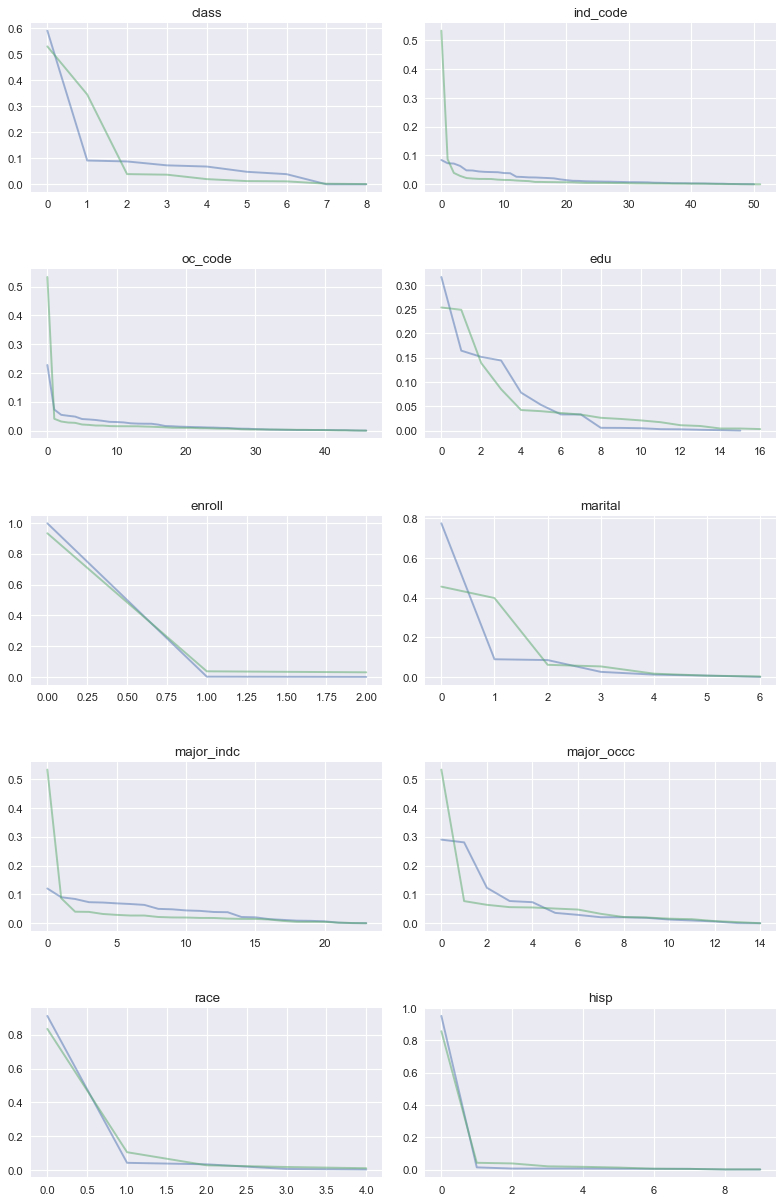

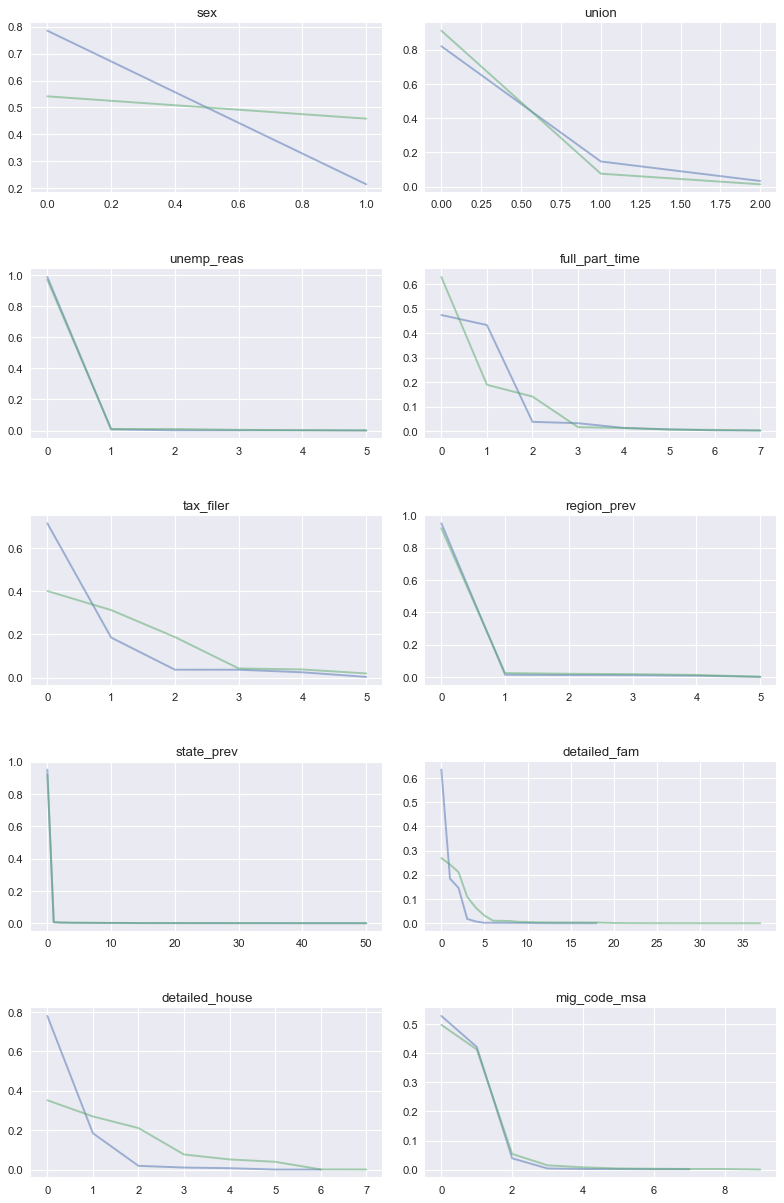

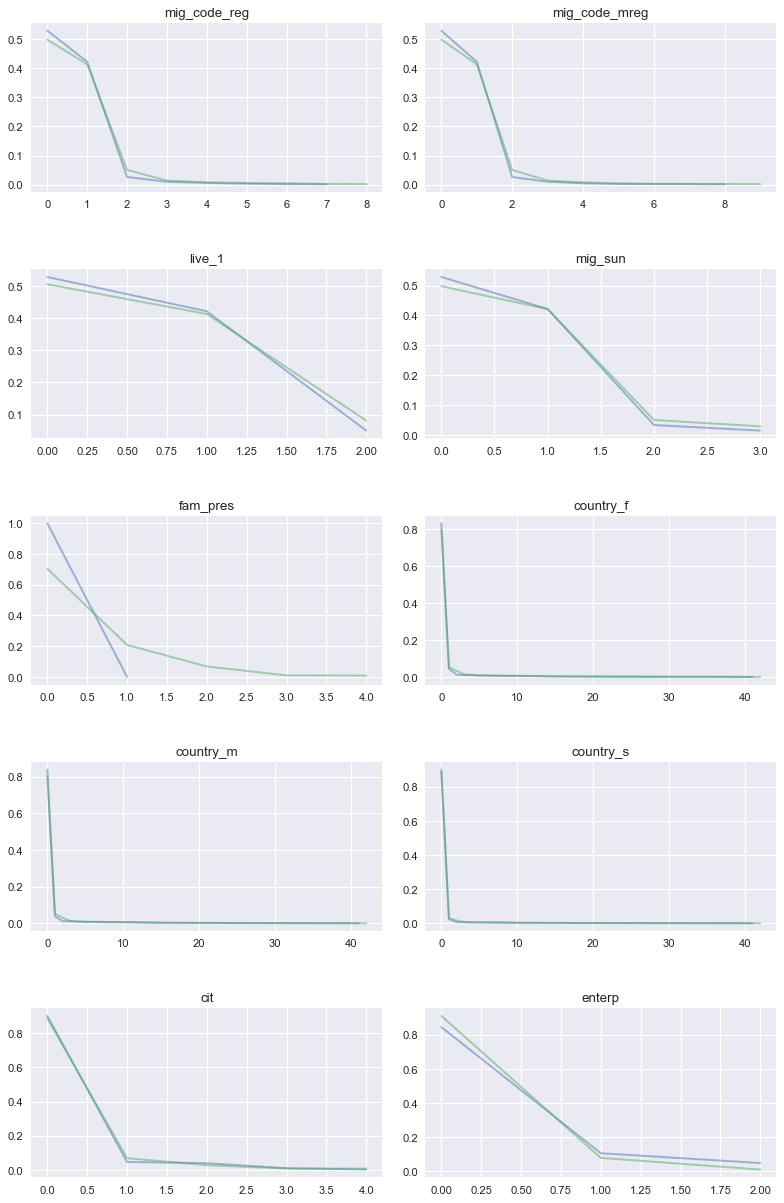

In [27]:
subset_0=df[nominal][df['inc_bin']==0]
subset_1=df[nominal][df['inc_bin']==1]

for n in range(3):
    fig1, axs1 = plt.subplots(5,2, figsize=(10,15),dpi=80, squeeze=False)
    fig1.tight_layout(h_pad=5.0)
    for ax1,i in zip(axs1, range(5*n, 5*(n+1))):
        for k in range(2):
            column=nominal[2*i+k]
            y0=subset_0[column].value_counts()/len(subset_0)
            x0=range(len(subset_0[column].unique()))
            x1=range(len(subset_1[column].unique()))
            x_vals=subset_1[column].unique()
            y1=subset_1[column].value_counts()/len(subset_1)
            axis=ax1[k]
            axis.plot(x1,y1, alpha=0.5)
            axis.plot(x0,y0, alpha=0.5)
            axis.set_title(column)

# class, ind_code/occ_code (0 or not 0), edu, marital (0, 1, 2+), race (remarkably similar!), sex, full_part_time, tax_filer,
# detailed_fam (0-5), detailed_house(0, 1, 2, 3+), live_1 surprisingly uncorrelated, fam_pres (almost ALWAYS both!),
# cit uncorrelated, vet_ben (none at 1 in 50k)

** Simple hypothesis testing **

What I'm doing: now I have an idea of the variables and what matters, I can look into how 50k+ individuals are different from 50k- individuals, using simple contingency tables.

Anything interesting? Yes!
- Some findings are expected: having capital gains (x6 more likely), working in management (x5), finance (x3), doctorate/masters, good to be self employed especially if incorporated, disadvantage to not be white or asian (-3x)
- Some surprising: specialty profession (x4), professional school degree (x8, same as phd), citizenship isn't that important
    (best to be naturalized actually)
- Some interesting variables are just capturing other correlations: "fam_pres" is just telling us if the person is a child. I'll create a categorical variable for this in the next section


In [28]:
#1 - do capital gains matter? Yes! 1/3rd of high rollers have high capital income.
high_rollers=df.ix[df.cap_gains > 2000]
x=high_rollers['inc_bin'].sum()/len(high_rollers)
print(x,'% of high rollers make 50k+')

0.36455811138014527 % of high rollers make 50k+


In [29]:
#2 categoricals. Does it help to work in finance? Does it help to be a manager?  
#Yes! 29% managers, finance is dissapointing with only 18%
def sumTable_cat(string, cutoff):
    x=df[[string, 'inc_bin']].groupby([string])
    summ=pd.concat([x.sum()/x.count(), x.count()], axis=1)
    summ.columns=['% 50k+', 'count']
    print(summ[summ.iloc[:,0]>cutoff], '\n')
sumTable_cat('major_occc', 0.2)
sumTable_cat('major_indc', 0.18)
sumTable_cat('race', 0.00)
sumTable_cat('edu', 0.1)
sumTable_cat('sex', 0.0)
sumTable_cat('detailed_house', 0.05) #either own a house or are spouse
sumTable_cat('cit', 0.05)
sumTable_cat('class', 0.10)
sumTable_cat('marital', 0.10)
sumTable_cat('tax_filer', 0.10)
sumTable_cat('fam_pres', 0.0)


                                   % 50k+  count
major_occc                                      
 Armed Forces                    0.222222     36
 Executive admin and managerial  0.287555  12495
 Professional specialty          0.249283  13940 

                                      % 50k+  count
major_indc                                         
 Armed Forces                       0.222222     36
 Communications                     0.228620   1181
 Finance insurance and real estate  0.182099   6145
 Mining                             0.259325    563
 Other professional services        0.232932   4482
 Utilities and sanitary services    0.217317   1178 

                                % 50k+   count
race                                          
 Amer Indian Aleut or Eskimo  0.021768    2251
 Asian or Pacific Islander    0.073693    5835
 Black                        0.026451   20415
 Other                        0.024884    3657
 White                        0.067350  167365 

    

# Part 3: Feature engineering and final data processing

Now I understand the raw data, and how the data is correlated with income, I'm going to make some new variables/change existing one.

**Binning**

Some features are interesting, but have too many categories with little (<1000) observations. To prevent overfitting, combine some categories.

In [30]:
#Bin detailed_fam
df.ix[~df.detailed_fam.isin([' Householder',' Child <18 never marr not in subfamily',
                              ' Spouse of householder', ' Nonfamily householder',
                              ' Child 18+ never marr Not in a subfamily', ' Secondary individual',
                              ' Other Rel 18+ ever marr not in subfamily',
                              ' Grandchild <18 never marr not in subfamily',
                              ' Child 18+ ever marr Not in a subfamily', 'detailed_fam']), 'detailed_fam']=' Others'

#Bin detailed_fam
df_test.ix[~df_test.detailed_fam.isin([' Householder',' Child <18 never marr not in subfamily',
                              ' Spouse of householder', ' Nonfamily householder',
                              ' Child 18+ never marr Not in a subfamily', ' Secondary individual',
                              ' Other Rel 18+ ever marr not in subfamily',
                              ' Grandchild <18 never marr not in subfamily',
                              ' Child 18+ ever marr Not in a subfamily', 'detailed_fam']), 'detailed_fam']=' Others'

#Bin country_m
df.ix[df.country_m.isin([' Italy', ' Canada', ' Germany', ' England', ' South Korea', ' Ireland',
                         ' Scotland', ' France', ' Holand_Netherlands']), 'country_m']=' Wealthy' 
df.ix[~df.country_m.isin([ ' United-States', ' Mexico' , ' ?', ' Puerto-Rico', ' Philippines', ' Poland',
                         ' El-Salvador', ' Dominican-Republic']), 'country_m']=' Others'

#Bin country_m
df_test.ix[df_test.country_m.isin([' Italy', ' Canada', ' Germany', ' England', ' South Korea', ' Ireland',
                         ' Scotland', ' France', ' Holand_Netherlands']), 'country_m']=' Wealthy' 
df_test.ix[~df_test.country_m.isin([ ' United-States', ' Mexico' , ' ?', ' Puerto-Rico', ' Philippines', ' Poland',
                         ' El-Salvador', ' Dominican-Republic']), 'country_m']=' Others'

#create hisp var
df.ix[(df.hisp) != ' All other', 'race']=' Hispanic'
df_test.ix[(df.hisp) != ' All other', 'race']=' Hispanic'

**Create new features**

I noticed some trends in my analysis earlier: 
- high capital gains/losses/dividends was correlated with 50k+. The correlation was less clear for low values of these variables, so to feed this to the model I'm creating a variable
- children are 25% of our dataset, and this could skew the age variable coefficients. Creating a new "children" variable instead.

In [31]:
df.ix[(df.cap_gains > 14000) |
         (df.cap_losses > 2000) |
         (df.dividends > 5000),
      'capital']='High'
df.ix[(df.capital != 'High'),
      'capital']=' Low'

df_test.ix[(df_test.cap_gains > 14000) |
         (df_test.cap_losses > 2000) |
         (df_test.dividends > 5000),
      'capital']='High'
df_test.ix[(df_test.capital != 'High'),
      'capital']=' Low'

In [32]:
def sumTable_cat(string, cutoff):
    x=df[[string, 'inc_bin']].groupby([string])
    summ=pd.concat([x.sum()/x.count(), x.count()], axis=1)
    summ.columns=['% 50k+', 'count']
    print(summ[summ.iloc[:,0]>cutoff], '\n')

In [33]:
df.age=df.age.astype(float)
df_test.age=df_test.age.astype(float)

df.ix[(df.age < 20),'child']='True'
df.ix[(df.child != 'True'),
     'child']='False'
df_test.ix[(df_test.age < 20),
     'child']='True'
df_test.ix[(df_test.child != 'True'),
     'child']='False'

In [34]:
sumTable_cat('capital', 0.0)
sumTable_cat('child', 0.0)

           % 50k+   count
capital                  
 Low     0.051918  195502
High     0.555086    4021 

         % 50k+   count
child                  
False  0.089260  138628
True   0.000131   60895 



# Phase 4 - logistic regression
    
What I'm doing: playtime's over, time for some modelling! Weaker assumptions on feature independence make this a decent pick for our data. We have to be careful mixing categorical and numeric data, so we use k-hot encoding for the categorical data.
- This model runs slowly, has a lot of features because of the k hot encoding
- Possible to interpret using log odds ratio - for the sake of the exercise, sense checked the signs of the numerical variables
- Difficulty: passing both the numeric and categorical variables to this model. Can use k encoding, but size of model explodes to 164 variables
- Model fits the test and the training datasets remarkably similarly -> doesn't seem to be overfitting. If I had more time, would also check all the parameter signs to see if they make sense, and interpret log odds ratios

** Select the features, encode all categoricals**

Removed redundant and uncorrelated/weakly correlated features that I discovered in phase 2.

In [35]:
nominal_feat=['class', 'edu', 'marital', 'race', 'sex', 'fam_pres',
          'full_part_time', 'tax_filer', 'detailed_fam', 'detailed_house',
         'mig_code_msa', 'country_m','enterp', 'child', 'capital']
continuous_feat=['age', 'wage', 'cap_gains', 'cap_losses', 'dividends', 'employer', 'weeks_w']
predict=['inc_bin']

In [36]:
#Model packages
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix
from sklearn import preprocessing


In [37]:
df_encoded=df[nominal_feat].apply(preprocessing.LabelEncoder().fit_transform)
df_encoded_test=df_test[nominal_feat].apply(preprocessing.LabelEncoder().fit_transform)

In [38]:
# A bit more pre-processing - categorical variables encoded to k vars
df_encoder=preprocessing.OneHotEncoder()
df_encoder.fit(df_encoded)
nom=df_encoder.transform(df_encoded)
nominal=nom.todense()
df_encoder.fit(df_encoded_test)
nom_test=df_encoder.transform(df_encoded_test)
nominal_test=nom_test.todense()

**Model and validation**

In [39]:
x_train=np.concatenate([nominal, df[continuous_feat].values], axis=1)
warnings.filterwarnings('ignore')

lr=LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=150, C=0.1)
#x_train=pd.concat([df[continuous], df_encoded[nominal]], axis=1)
#x_train=df_encoded[nominal_feat].values
X=x_train
y=df[predict].values.ravel()
lr.fit(X,y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=150, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
#Set up validity test
expected=y
predicted=lr.predict(X)
score_train = lr.score(X, y)

df_encoder.fit(df_encoded_test)
nom_test=df_encoder.transform(df_encoded_test)
nominal_test=nom_test.todense()

x_test=np.concatenate([nominal_test, df_test[continuous_feat].values], axis=1)
X_test=x_test
y_test=df_test[predict].values.ravel()
expected_test=y_test
predicted_test=lr.predict(X_test)

In [41]:
#Test
from sklearn import metrics
# f1 scores
score = metrics.f1_score(y_test, predicted_test)
score_train = metrics.f1_score(y, predicted)

# pscores
pscore_train = metrics.accuracy_score(y_test, predicted_test)
pscore = metrics.accuracy_score(y, predicted)

#recall
recscore = metrics.recall_score(y, predicted)
recscore_train = metrics.recall_score(y_test, predicted_test)

#Confusion matrix
matrix=metrics.confusion_matrix(y_test,predicted_test)
matrix_train=metrics.confusion_matrix(y, predicted)

print('train recall score:', recscore)
print('train precision score:', pscore)
print('train f1:',score_train)
print('train confusion matrix: \n', matrix_train)

print('\ntest recall score:', recscore_train)
print('test precision score:', pscore_train)
print('test f1:',score)
#print('test confusion matrix: \n', matrix)

train recall score: 0.328379906316
train precision score: 0.950276409236
train f1: 0.450451448513
train confusion matrix: 
 [[185536   1605]
 [  8316   4066]]

test recall score: 0.323472356935
test precision score: 0.950271646519
test f1: 0.446502287181


In [42]:
#Sense check - do the coefficients on the numerical variables make sense? Mostly positive - as age, wage, weeks worked,
# cap gains/losses/dividends increase, so does the probability of earniing 50k+. This makes sense.
print(lr.coef_[:,-7:])

[[  1.57237718e-02  -3.55289659e-05   3.63239438e-05   2.22724576e-04
    6.56664576e-05   9.21557158e-02   2.03837908e-02]]


# Phase 5 - Decision tree

- Given that Naive Bayesian makes poor assumptions, and logistic doesn't allow us to exploit all our information, it seems a decision tree might be the best solution, but there is a risk of overfitting with this many parameters

In [43]:
nominal_feat=['class', 'edu', 'marital', 'major_indc', 'major_occc', 'race', 'sex', 'fam_pres',
          'full_part_time', 'tax_filer', 'detailed_fam', 'detailed_house',
         'mig_code_msa', 'country_m','enterp', 'child', 'capital']
continuous_feat=['age', 'wage', 'cap_gains', 'cap_losses', 'dividends', 'employer', 'weeks_w']
predict=['inc_bin']

from sklearn import preprocessing

df_encoded=df[nominal_feat].apply(preprocessing.LabelEncoder().fit_transform)
df_encoded_test=df_test[nominal_feat].apply(preprocessing.LabelEncoder().fit_transform)

#Model
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix

# A bit more pre-processing - categorical variables encoded to k vars
df_encoder=preprocessing.OneHotEncoder()
df_encoder.fit(df_encoded)
nom=df_encoder.transform(df_encoded)
nominal=nom.todense()

df_encoder.fit(df_encoded_test)
nom_test=df_encoder.transform(df_encoded_test)
nominal_test=nom_test.todense()

In [44]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

x_train=np.concatenate([nominal, df[continuous_feat].values], axis=1)
print(x_train.shape)
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
#x_train=pd.concat([df_encoded[nominal_feat], df[continuous_feat]], axis=1)
X=x_train
y=df[predict].values.ravel()
dt.fit(X,y)

(199523, 150)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=99, splitter='best')

In [45]:
#Set up variables for validity test
expected=y
predicted=dt.predict(X)
x_test=np.concatenate([nominal_test, df_test[continuous_feat].values], axis=1)
print(x_test.shape)
#x_test=pd.concat([df_encoded_test[nominal_feat], df_test[continuous_feat]], axis=1)
#X_test=x_test
y_test=df_test[predict].values.ravel()
expected_test=y_test
predicted_test=dt.predict(x_test)


(99762, 150)


In [46]:
from sklearn import metrics
# f1 scores
score = metrics.f1_score(y_test, predicted_test)
score_train = metrics.f1_score(y, predicted)

# pscores
pscore_train = metrics.accuracy_score(y_test, predicted_test)
pscore = metrics.accuracy_score(y, predicted)

#recall
recscore = metrics.recall_score(y, predicted)
recscore_train = metrics.recall_score(y_test, predicted_test)
score_train = dt.score(X, y)

#Confusion matrix
matrix=metrics.confusion_matrix(y_test,predicted_test)
matrix_train=metrics.confusion_matrix(y, predicted)

print('train recall score:', recscore)
print('train precision score:', pscore)
print('train f1:',score_train)
print('train confusion matrix: \n', matrix_train)

print('\ntest recall score:', recscore_train)
print('test precision score:', pscore_train)
print('test f1:',score)
print('test confusion matrix: \n', matrix)

train recall score: 0.648441285737
train precision score: 0.97061992853
train f1: 0.97061992853
train confusion matrix: 
 [[185632   1509]
 [  4353   8029]]

test recall score: 0.464112512124
test precision score: 0.946161865239
test f1: 0.516692162332
test confusion matrix: 
 [[91520  2056]
 [ 3315  2871]]


**Example of a (very) simplified decision tree** - Open in new tab for clear view. Capital gains, dividends, weeks worked and tax filing status are all important features.

http://i.imgur.com/b3n4NmK.png

# Phase 6 - Random Forest

- To guard against overfitting, maybe random forest is more appropriate
- Difficulties: still getting overfitted values. Looked at feature importance and removed the unimportant ones, increased the number of estimators and decreased the max depth per tree
- Final tweaking: ran hyper optimization
- In a setting like this one, we may be using the 50k+ label to market to customers. Better to over-predict than under-predict. If we were to implement this model, we could lower the threshold p(50k+)<0.5 to find customers relatively likely to be making 50k+

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

ranFor = RandomForestClassifier(n_estimators=100, bootstrap=False, criterion='entropy',max_depth=10, min_samples_leaf=5, min_samples_split=10)
x_train=np.concatenate([nominal, df[continuous_feat].values], axis=1)
X=x_train
y=df[predict].values.ravel()
ranFor.fit(X,y)

#set bootstrap to true to reduce - min_samples_split: taille minimum de ton echantillon pour faire un split
#min samples split: when does he stop?
#lire la documentation de scikit learn
#bias - variance tradeoff: bias is how far you are from the true model, variance tells you the fluctuation of your prediction.
#variance importante dans un decision tree
#scikit learn - peux combiner, faire des clusters - hyperopt to optimize features

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [48]:
#Set up variables for model testing
expected=y
predicted=ranFor.predict(X)

x_test=np.concatenate([nominal_test, df_test[continuous_feat].values], axis=1)
X_test=x_test
y_test=df_test[predict].values.ravel()
expected=y_test
predicted_test=ranFor.predict(X_test)

In [49]:
from sklearn import metrics

# f1 scores
score = metrics.f1_score(y_test, predicted_test)
score_train = metrics.f1_score(y, predicted)

# pscores
pscore = metrics.accuracy_score(y_test, predicted_test)
pscore_train = metrics.accuracy_score(y, predicted)

#recall
recscore_train = metrics.recall_score(y, predicted)
recscore = metrics.recall_score(y_test, predicted_test)

#Confusion matrix
matrix=metrics.confusion_matrix(y_test,predicted_test)
matrix_train=metrics.confusion_matrix(y, predicted)

print('train recall score:', recscore_train)
print('train precision score:', pscore_train)
print('train f1:',score_train)
print('train confusion matrix: \n', matrix_train)
print('\ntest recall score:', recscore)
print('test precision score:', pscore)
print('test f1:',score)
print('test confusion matrix: \n', matrix)

train recall score: 0.188337909869
train precision score: 0.948447046205
train f1: 0.311973244147
train confusion matrix: 
 [[186905    236]
 [ 10050   2332]]

test recall score: 0.174749434206
test precision score: 0.947084060063
test f1: 0.290552345115
test confusion matrix: 
 [[93402   174]
 [ 5105  1081]]


# Appendix 

This contains some old code that could easily be recalibrated to run on the above. Because it is out of order, it will require a bit of tweaking to run. Useful for extension work.

**Extension 1: Model Calibration **

Optimizing the parameters passed to sklearn. This is a final tuning step, just run once at the end for a tiny improvement.

In [ ]:
#Model fine tuning - this takes a while to run.

import numpy as np
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
x_train=pd.concat([df_encoded[nominal_feat], df[continuous_feat]], axis=1)
X=x_train.values
y=df[predict].values.ravel()

In [ ]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(ranFor, param_distributions=param_dist,
                                   n_iter=n_iter_search)
start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

**Extension 2: Naive Bayesian**
    
What I'm doing: quick, 5 minute bayesian model that's making awful assumptions (1 with gaussian numeric variables, 1 with multinomial categorical variables)
   
Anything interesting: no, it's awful at 91% accuracy and the assumptions on the variable distributions do not hold. Recall values aren't great.


In [ ]:
# Naive bayes - Gaussian, for continuous. Clearly independence does not hold but let's give it a shot. 
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

x=df[continuous_feat].values
y=df[predict].values.ravel()
model1=GaussianNB()
model1.fit(x, y)

expected=y
predicted=model1.predict(x)
print('training data \n' + metrics.classification_report(expected, predicted))

x2=df_test[continuous_feat].values
expected2=df_test[predict].values.ravel()
predicted2=model1.predict(x2)
print('test data \n' + metrics.classification_report(expected2, predicted2))

#91% accuracy, worst than baseline.

In [ ]:
# Naive bayes - multinomial, for categorical variables

from sklearn.naive_bayes import MultinomialNB

x=df_encoded.values
y=df[predict].values.ravel()
model1=MultinomialNB()
model1.fit(x, y)

expected=y
predicted=model1.predict(x)
print('training data \n' + metrics.classification_report(expected, predicted))

x2=df_encoded_test.values
expected2=df_test[predict].values.ravel()
predicted2=model1.predict(x2)
print('test data \n'+ metrics.classification_report(expected2, predicted2))


**Extension 3 Feature selection** 
I created some simple simple binary indicators from the test data, and ran the models with the numeric variables.
This isn't perfect, but it gives me an idea of which kinds of variables the model is using, giving me a bit of model interpretation and an idea of which features were worth including in my model.

In [ ]:
#Model results: feature importance
features=np.concatenate([nominal_feat, continuous_feat])
importance=ranFor.feature_importances_
importance = pd.DataFrame(importance, index=features, 
                          columns=["Importance"])
print(importance.sort_values('Importance'))